# Instrument Lineshapes

MATS has added the capability to simulate and fit spectra using an instrument lineshape.  MATS automatically loads the slit functions defined in HAPI, but could use any slit function with the form slit_function(x, resolution) or slit_function(x, [resolutions]).  MATS uses a slight variation of the HAPI convolveSpectrumSame, where the arange_ function was redefined to address a integer/float bug in the underlying np.linspace call.  This implementation currently assumes an equal wavenumber spacing.

The example below simulates the same spectrum and applies the different HAPI instrument line shapes.  The simulated molefraction is perturbted and then floated during a fit.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from scipy import interpolate
import seaborn as sns

sys.path.append(r'C:\Users\ema3\Documents\MATS\MATS')# set location of HAPI.py module
%matplotlib inline
from MATS import *


HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


## Simulate Spectra with ILS

The spectrum object definitions show how to use the ILS_function, ILS_resolution, and ILS_wing (defines the length of the ILS slit function to use in the convolution, such that the length is +/- ILS_wing / spectrum stepsize) to define the ILS function.  The outputs below show the generated spectrum for each ILS_function

Rectangular


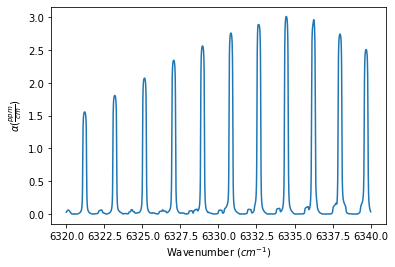

Triangular


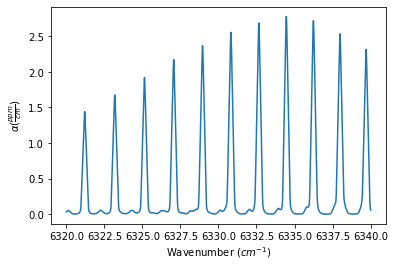

Gaussian


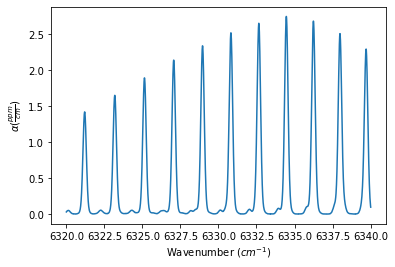

Dispersion


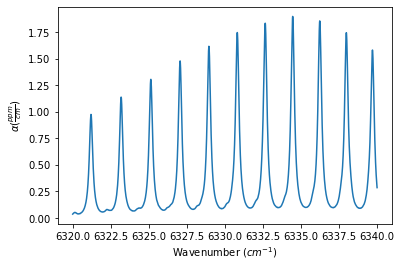

Cosinus


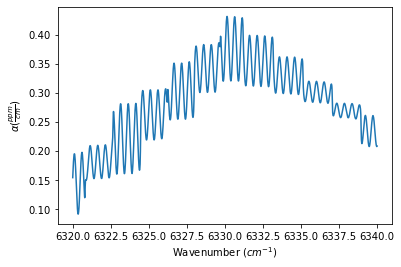

Diffraction


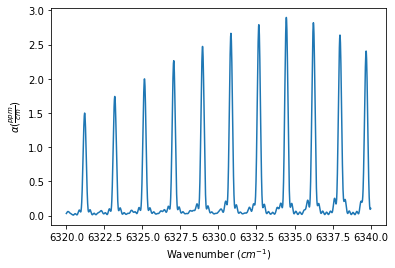

Michelson


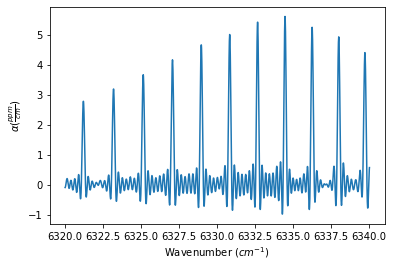

In [2]:
linelist = r'C:\Users\ema3\Documents\MATS\MATS\Linelists' # Location of the Summary Data File
os.chdir(linelist)
PARAM_LINELIST = pd.read_csv('CO2_30012.csv')

path = r'C:\Users\ema3\Documents\MATS\MATS\Examples\Instrument Lineshape' # Location of the Summary Data File
os.chdir(path)


IntensityThreshold = 1e-30 #intensities must be above this value to be simulated
Fit_Intensity = 1e-24#intensities must be above this value for the line to be fit
wave_range = 1.5 #range outside of experimental x-range to simulate
IntensityThreshold = 1e-30 #intensities must be above this value to be simulated
segment_column = None
order_baseline_fit = 1
etalon = {}
SNR = 5000
resolution = 0.25
molefraction = {2:0.01}
wave_min = 6320
wave_max = 6340
wave_step = 0.01

PARAM_LINELIST = PARAM_LINELIST[(PARAM_LINELIST['nu'] <= wave_max + wave_range) & (PARAM_LINELIST['nu']>= wave_min - wave_step)]


spec_rectangular =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_step,
                                SNR = SNR, baseline_terms = [0], temperature = 22.85,  
                                pressure = 150, 
                                 filename = 'Rectangular', 
                               molefraction =  {2:0.01} , ILS_function = SLIT_RECTANGULAR, ILS_resolution = resolution, ILS_wing = 10)
spec_triangular=  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_step,
                                SNR = SNR, baseline_terms = [0], temperature = 22.85,  
                                pressure = 150, 
                                 filename = 'Triangular', 
                               molefraction =  {2:0.01}, ILS_function = SLIT_TRIANGULAR, ILS_resolution = resolution, ILS_wing = 10)
spec_gaussian =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_step,
                                SNR = SNR, baseline_terms = [0], temperature = 22.85,  
                                pressure = 150, 
                                 filename = 'Gaussian', 
                               molefraction =  {2:0.01}, ILS_function = SLIT_GAUSSIAN, ILS_resolution = resolution, ILS_wing = 10)
spec_dispersion =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_step,
                                SNR = SNR, baseline_terms = [0], temperature = 22.85,  
                                pressure = 150, 
                                 filename = 'Dispersion', 
                               molefraction =  {2:0.01}, ILS_function = SLIT_DISPERSION, ILS_resolution = resolution, ILS_wing = 10)
spec_cosinus =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_step,
                                SNR = SNR, baseline_terms = [0], temperature = 22.85,  
                                pressure = 150, 
                                 filename = 'Cosinus', 
                               molefraction =  {2:0.01}, ILS_function = SLIT_COSINUS, ILS_resolution = resolution, ILS_wing = 10)
spec_diffraction =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_step,
                                SNR = SNR, baseline_terms = [0], temperature = 22.85,  
                                pressure = 150, 
                                 filename = 'Diffraction', 
                               molefraction =  {2:0.01}, ILS_function = SLIT_DIFFRACTION, ILS_resolution = resolution, ILS_wing = 10)
spec_michelson =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_step,
                                SNR = SNR, baseline_terms = [0], temperature = 22.85,  
                                pressure = 150, 
                                 filename = 'Michelson', 
                               molefraction =  {2:0.01}, ILS_function = SLIT_MICHELSON, ILS_resolution = resolution, ILS_wing = 10)
print ('Rectangular')
spec_rectangular.plot_wave_alpha()
print ('Triangular')
spec_triangular.plot_wave_alpha()
print ('Gaussian')
spec_gaussian.plot_wave_alpha()
print ('Dispersion')
spec_dispersion.plot_wave_alpha()
print ('Cosinus')
spec_cosinus.plot_wave_alpha()
print ('Diffraction')
spec_diffraction.plot_wave_alpha()
print ('Michelson')
spec_michelson.plot_wave_alpha()

## Generate Fit Parameters

The CO2 molefraction is perturbed from the initial guess. Normally distributed 2% random uncertainy put on the initial mole fraction guess.

In addition to the normal line shape and baseline parameters the ILS resolution parameters are also fittable parameters.  This is also coded in such a way that different spectra can have different ILS functions and the baseline linelist table adequately accounts for this.  While floating the resolution parameters is possible, it should be done with caution as all other parameters are dependent on this value, so correlation and poor fits are likely.   

In [3]:
SPECTRA = Dataset([ spec_rectangular, spec_triangular, spec_gaussian, spec_dispersion, spec_cosinus, 
                               spec_diffraction, spec_michelson],  'ILS Study', PARAM_LINELIST) 
BASE_LINELIST = SPECTRA.generate_baseline_paramlist()

BASE_LINELIST['molefraction_CO2'] = BASE_LINELIST['molefraction_CO2'].values*(1 + np.random.normal(loc = 0, scale =1, size = len(BASE_LINELIST['molefraction_CO2']))*(2/100)) #Adjust the mole fraction of each sample by a mole fraction of random value normally distributed 2%




FITPARAMS = Generate_FitParam_File(SPECTRA, PARAM_LINELIST, BASE_LINELIST,
                                           lineprofile = 'SDNGP', linemixing = True, 
                                              fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, 
                                              nu_constrain = True, sw_constrain = True, gamma0_constrain = True, delta0_constrain = True, 
                                               aw_constrain = True, as_constrain = True, 
                                               nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True) 


FITPARAMS.generate_fit_param_linelist_from_linelist(vary_nu = {2:{1:False, 2:False, 3:False}}, vary_sw = {2:{1:False, 2:False, 3:False}},
                                                    vary_gamma0 = {2:{1: False, 2:False, 3: False}}, vary_n_gamma0 = {2:{1:False}}, 
                                                    vary_delta0 = {2:{1:False, 2:False, 3: False}}, vary_n_delta0 = {2:{1:False}}, 
                                                    vary_aw = {2:{1: False, 2:False, 3: False}}, vary_n_gamma2 = {2:{1:False}}, 
                                                    vary_as = {2:{1:False}}, vary_n_delta2 = {2:{1:False}}, 
                                                    vary_nuVC = {2:{1:False}}, vary_n_nuVC = {2:{1:False}},
                                                    vary_eta = {}, vary_linemixing = {2:{1:False}})

FITPARAMS.generate_fit_baseline_linelist(vary_baseline = False, vary_molefraction = {2:True}, vary_ILS_res = False)

,Segment Number,Pressure,Pressure_err,Pressure_vary,SLIT_COSINUS_res_0,SLIT_COSINUS_res_0_err,SLIT_COSINUS_res_0_vary,SLIT_DIFFRACTION_res_0,SLIT_DIFFRACTION_res_0_err,SLIT_DIFFRACTION_res_0_vary,...,Temperature_vary,baseline_a,baseline_a_err,baseline_a_vary,molefraction_CO2,molefraction_CO2_err,molefraction_CO2_vary,x_shift,x_shift_err,x_shift_vary
Spectrum Number,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.197368,0,False,0.00,0,False,0.00,0,False,...,False,0.0,0,False,0.010211,0,True,0.0,0,False
2.0,0.0,0.197368,0,False,0.00,0,False,0.00,0,False,...,False,0.0,0,False,0.010278,0,True,0.0,0,False
3.0,0.0,0.197368,0,False,0.00,0,False,0.00,0,False,...,False,0.0,0,False,0.009493,0,True,0.0,0,False
4.0,0.0,0.197368,0,False,0.00,0,False,0.00,0,False,...,False,0.0,0,False,0.010147,0,True,0.0,0,False
5.0,0.0,0.197368,0,False,0.25,0,False,0.00,0,False,...,False,0.0,0,False,0.010060,0,True,0.0,0,False
6.0,0.0,0.197368,0,False,0.00,0,False,0.25,0,False,...,False,0.0,0,False,0.010319,0,True,0.0,0,False
7.0,0.0,0.197368,0,False,0.00,0,False,0.00,0,False,...,False,0.0,0,False,0.009962,0,True,0.0,0,False


# Fit Data

Name                           Value      Min      Max   Stderr     Vary     Expr Brute_Step
Pressure_1_0                  0.1974     -inf      inf        0    False     None     None
Pressure_2_0                  0.1974     -inf      inf        0    False     None     None
Pressure_3_0                  0.1974     -inf      inf        0    False     None     None
Pressure_4_0                  0.1974     -inf      inf        0    False     None     None
Pressure_5_0                  0.1974     -inf      inf        0    False     None     None
Pressure_6_0                  0.1974     -inf      inf        0    False     None     None
Pressure_7_0                  0.1974     -inf      inf        0    False     None     None
SD_delta_air_line_101              0     -inf      inf        0    False     None     None
SD_delta_air_line_156              0     -inf      inf        0    False     None     None
SD_delta_air_line_204              0     -inf      inf        0    False     None     No

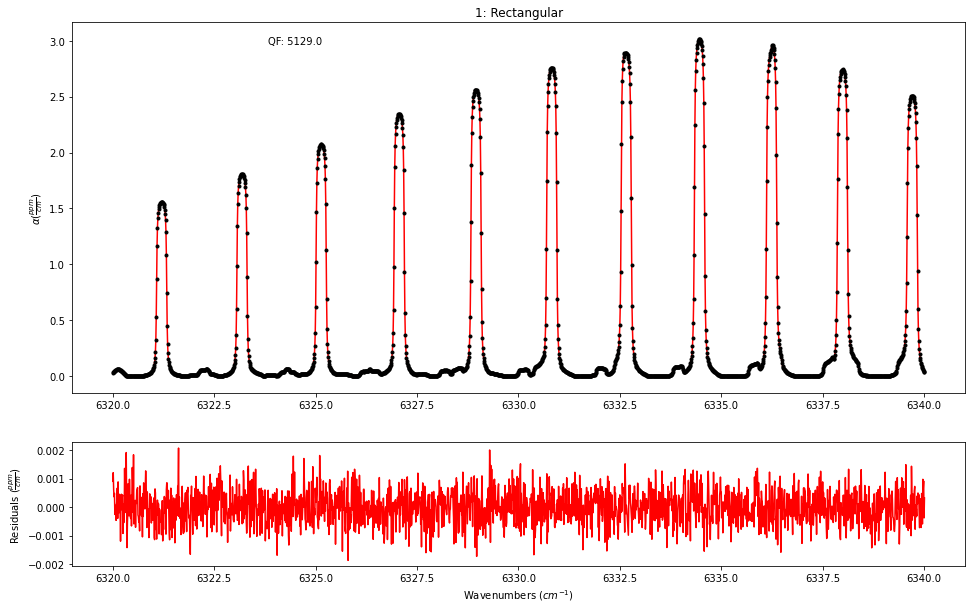

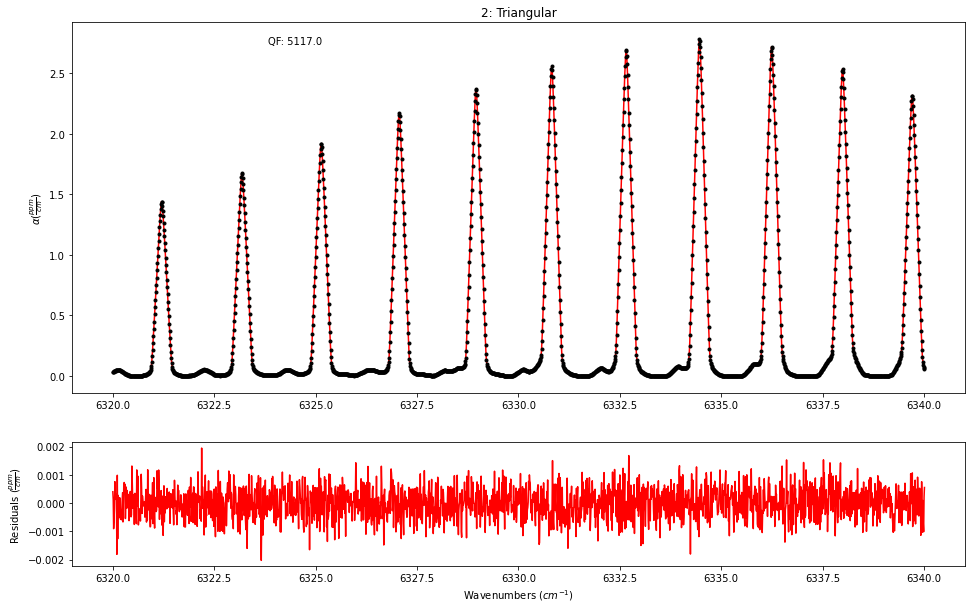

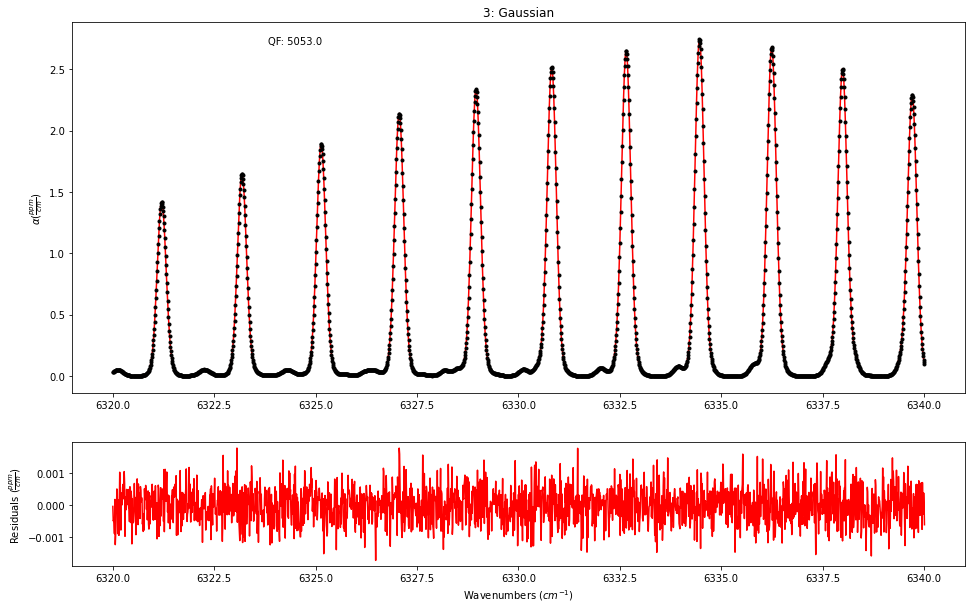

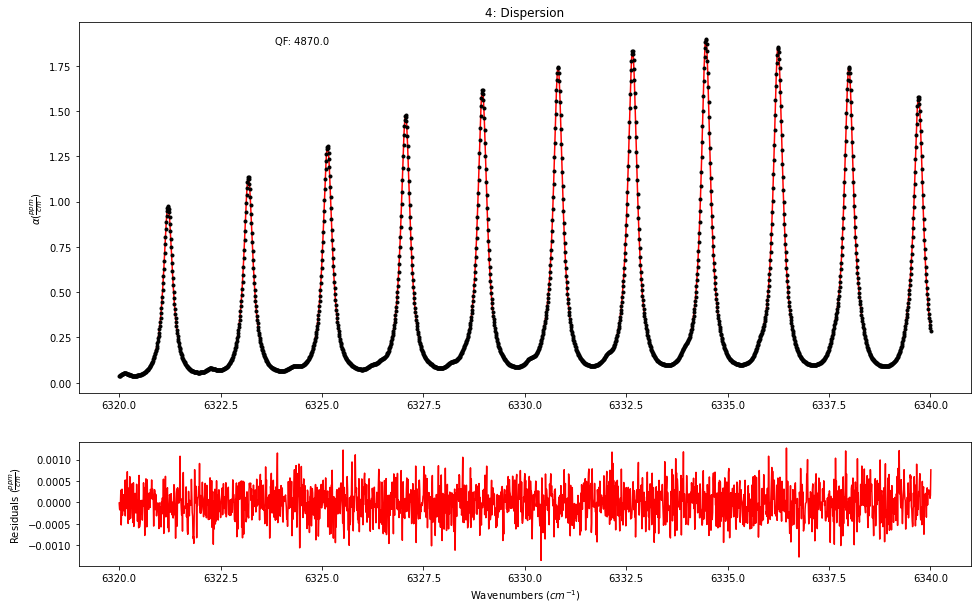

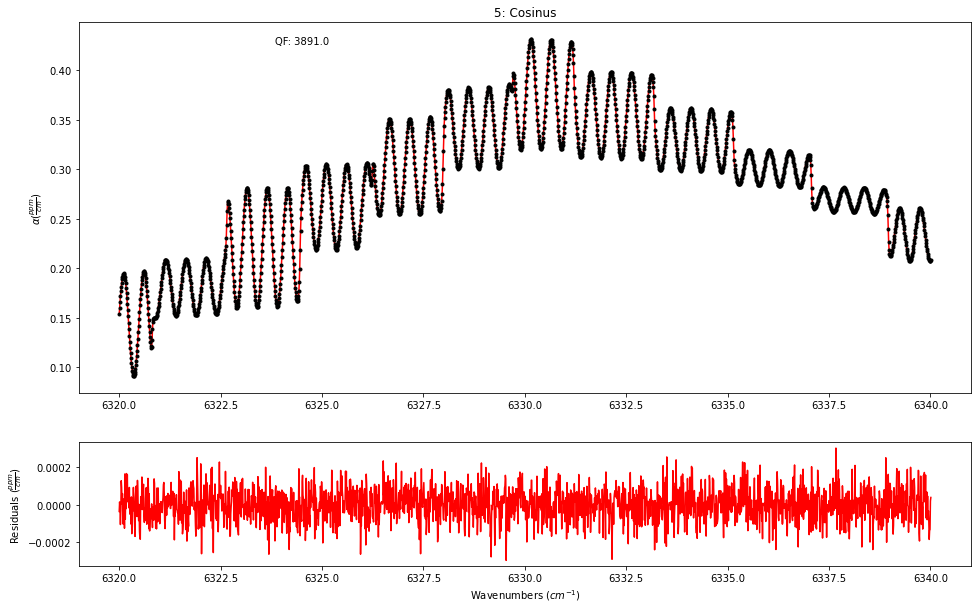

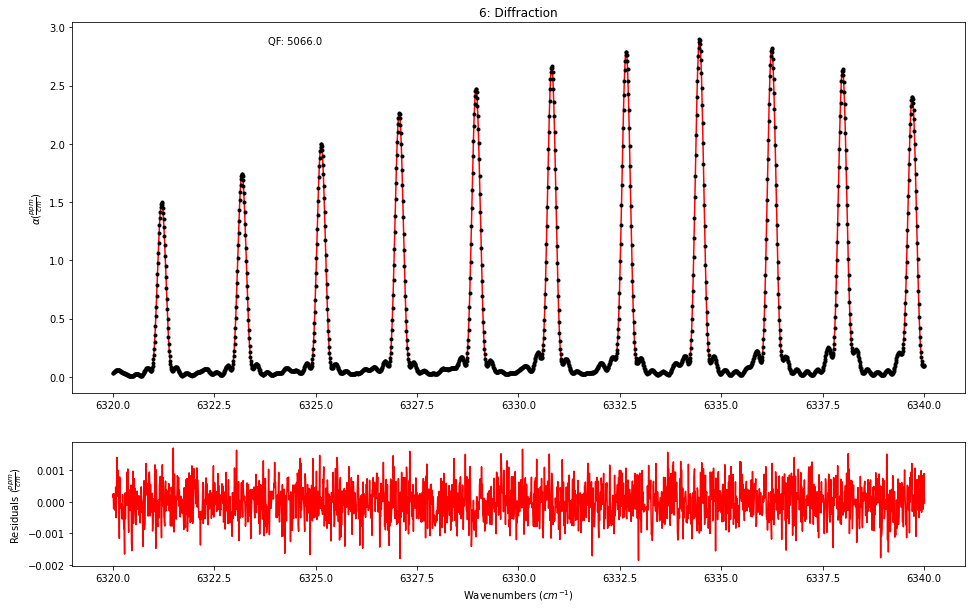

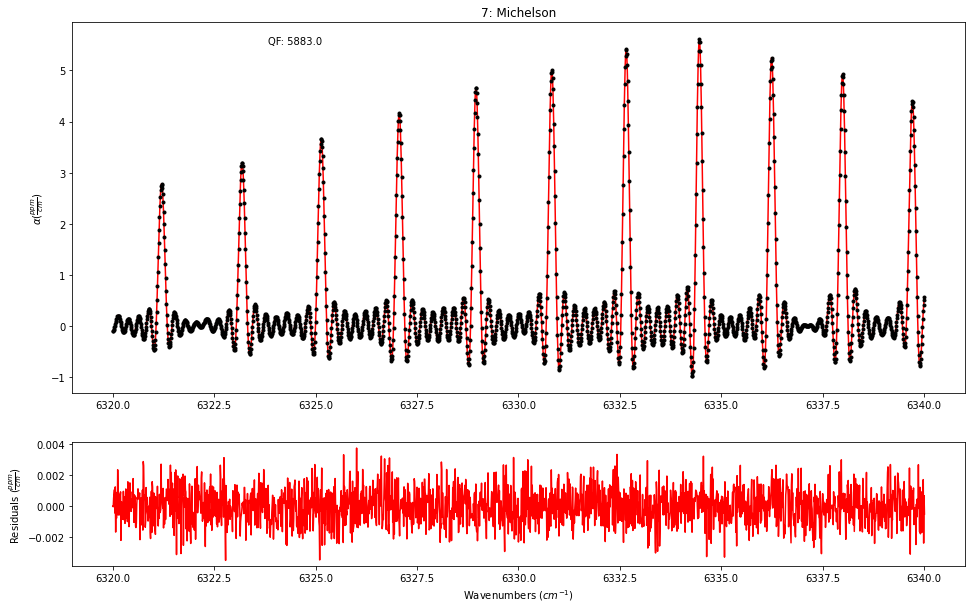

,Spectrum Number,Spectrum Name,Frequency (MHz),Wavenumber (cm-1),Pressure (Torr),Temperature (C),Tau (us),Tau Error (%),Alpha (ppm/cm),Model (ppm/cm),Residuals (ppm/cm),QF,Background,CIA (ppm/cm)
0,1,Rectangular,1.894688e+08,6320.00,150.0,22.85,1175.673928,0.012724,0.028372,0.029280,0.000908,5129.0,0.0,0
1,1,Rectangular,1.894691e+08,6320.01,150.0,22.85,996.402101,0.012724,0.033477,0.034690,0.001213,5129.0,0.0,0
2,1,Rectangular,1.894694e+08,6320.02,150.0,22.85,888.907841,0.012724,0.037525,0.038147,0.000622,5129.0,0.0,0
3,1,Rectangular,1.894697e+08,6320.03,150.0,22.85,833.343246,0.012724,0.040027,0.040391,0.000364,5129.0,0.0,0
4,1,Rectangular,1.894700e+08,6320.04,150.0,22.85,794.326442,0.012724,0.041993,0.042476,0.000483,5129.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,7,Michelson,1.900675e+08,6339.97,150.0,22.85,226.422517,0.025810,0.147319,0.145878,-0.001441,5883.0,0.0,0
1998,7,Michelson,1.900678e+08,6339.98,150.0,22.85,113.961380,0.013929,0.292699,0.294403,0.001704,5883.0,0.0,0
1999,7,Michelson,1.900681e+08,6339.99,150.0,22.85,79.176669,0.043070,0.421291,0.418894,-0.002397,5883.0,0.0,0
2000,7,Michelson,1.900684e+08,6340.00,150.0,22.85,65.074071,0.013929,0.512591,0.513257,0.000666,5883.0,0.0,0


In [4]:
fit_data = Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', minimum_parameter_fit_intensity = Fit_Intensity)
params = fit_data.generate_params()
for param in params:
    if ('_res_' in param) and (params[param].vary == True):
        params[param].set(min = 0.01)
        
result = fit_data.fit_data(params)
print (result.params.pretty_print())
fit_data.residual_analysis(result, indv_resid_plot=True)
fit_data.update_params(result)
SPECTRA.generate_summary_file(save_file = True)